# Machine Learning Model

First, we must import the necessary libraries:
- `parsing`: a set of functions required to parse a csv into the three data frames we need
    - Patients
    - Appointments
    - Weather
- `database_functions`: these functions handle the creation of the database, as well as pushing tables to the database and querying said tables.
- `ml_functions`: a set of functions that perform every aspect of training, testing, and evaluating the model. 

In [12]:
from parsing import *
from database_functions import *
from ml_functions import *
import skimage.io as io
from IPython.display import Image

## Parsing
First, we parse the data, given a csv file, using the `parsing` function. We will also use `create_df` to merge these according to related columns. Some quick descriptive statistics indicate that the dataset is imbalanced, meaning that the number of positive labels (cancellations) is outweighed significantly by the number of negative labels (shows)

In [2]:
patients, appointments, weather = parsing(data_raw_fname = '/Users/jenniferpolson/Documents/School/2017-F/BE 223A/Midterm Project/be223a_dataset.csv', 
                                          encoding=None, 
                                          dtformat='%m/%d/%y %H:%M', 
                                          exam_id = 'Exam ID', pt_id = 'Patient ID', age = 'Age', gender = 'Gender')
df = create_df(appointments, patients, weather, 'Patient_ID', 'Dayofyear')

Reading /Users/jenniferpolson/Documents/School/2017-F/BE 223A/Midterm Project/be223a_dataset.csv
Processed in 3.818 seconds.


## Machine Learning Model
There are many aspects to running a machine learning model. The function `run model` actually handles everything for us. We just need to pass it the dataframe generated from the parsing section, and specify one aspect:
- `tune_parameters`: if this is True, then the function will use a Grid Search to find the best parameters for the model (more on that later)
There are also some default parameters that you can change if you want:
- `exam_id, patient_id, drops`: if you are using a dataset different than the one we are using, then exam_id and patient_id might be different for you. `drops` refers to any columns in the data that you don't want to put into the model.
- `k = 5000`: the number of cases you want to use for each category in the Grid Search
---
Here is what `run_model` does:
1. Creates a separate data frame with patient IDs, Exam IDs, and the indices, called `ids`
2. Calls `model_preprocess` to undersample the dominant class using Edited Nearest Neighbors, a technique that involves clustering the data, and choosing from those clusters. This outputs a test set with the same distribution as the total set, and a training set that is more balanced.
3. Runs the `RandomForestClassifier` from the `sklearn` library. If `model_preprocess` was run, it uses those parameters; if not, default parameters are specified from manual tuning. The function uses the builtin methods to predict the labels as well as the probabilities for each test case. 
4. The function then performs a series of analyses:
    - `rfc_metrics`: generates the standard measures of performance (accuracy, precision, recall F-1), and plots the ROC AUC.
    - `show_confusion_matrix`: with those metrics generated above, this function generates a confusion matrix and reports them, along with the confusion matrix.
    - `prob_cm`: this takes the probabilities predicted from the model, puts them into bins (e.g., 0.1-0.2) and plots the false and true values for each bin.
    - `feat_imprt`: this takes the fitted Random Forest, and plots the features in order of their importance to the classifier model. 
5. This function then outputs:
    - `results`: the probabilities and labels for each test case
    - `prob`: the confusion matrices for each probability bin
    - `groups`: a `groupby` object that contains the binning for the probabilities
    - `test`: the test dataset, with the labels attached
    - `evalstats` an array with all of the evaluation statistics

Preprocessing Completed in 94.694 seconds.
Running GridSearch. Tuned Parameters:


{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_features': 0.5,
 'n_estimators': 110}

Grid Search Performed in 3901.737 seconds.
Running the Random Forest Classifier.
Feature ranking:


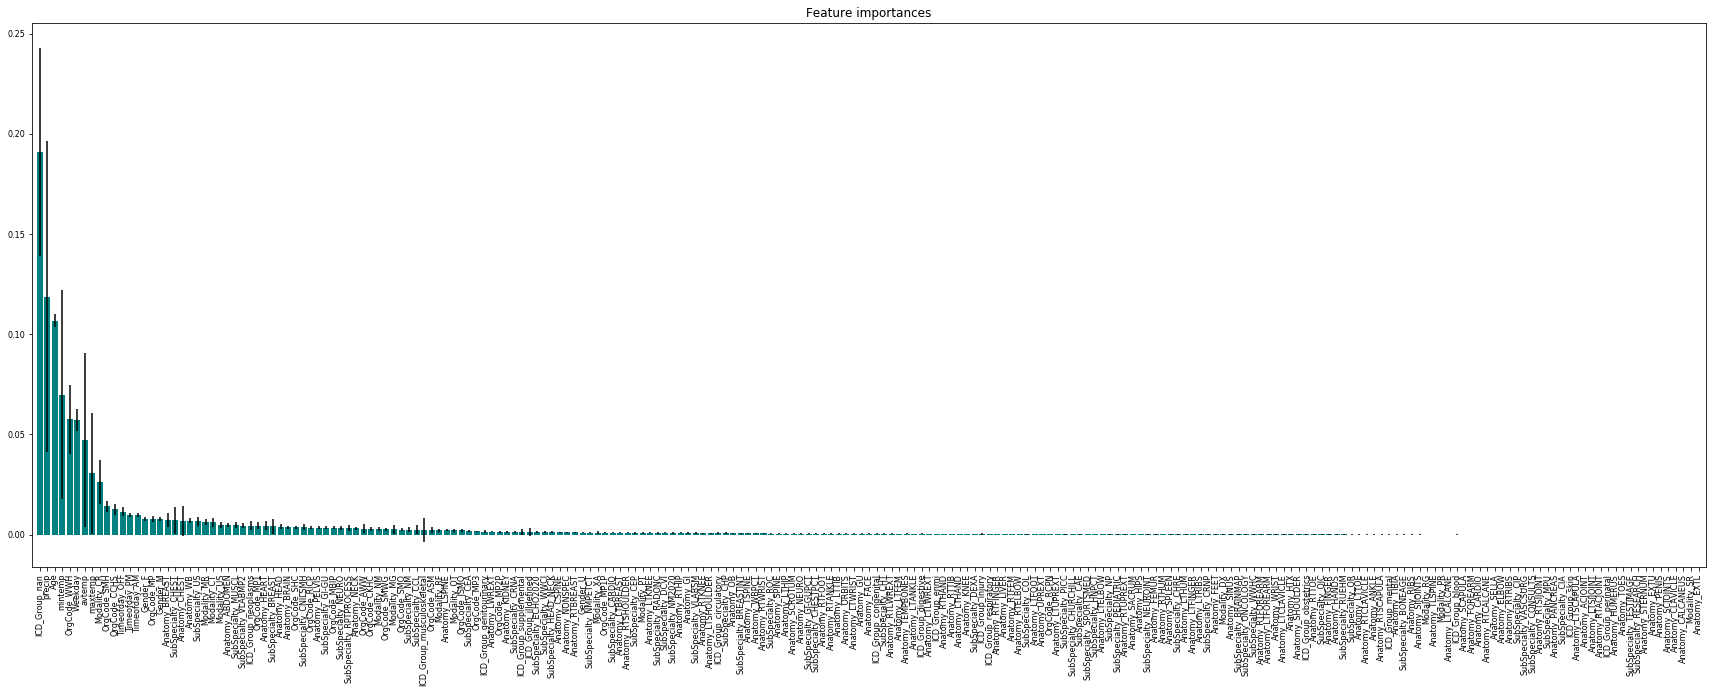

Random Forest Classifier Model run in 157.088 seconds.


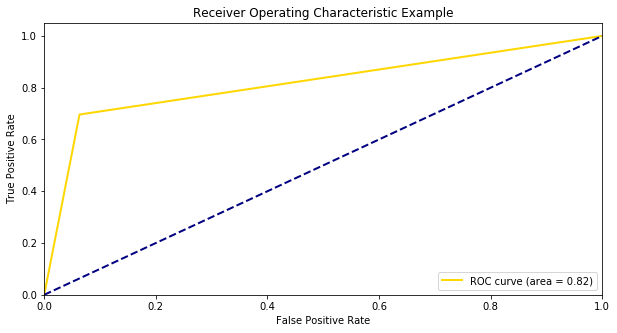

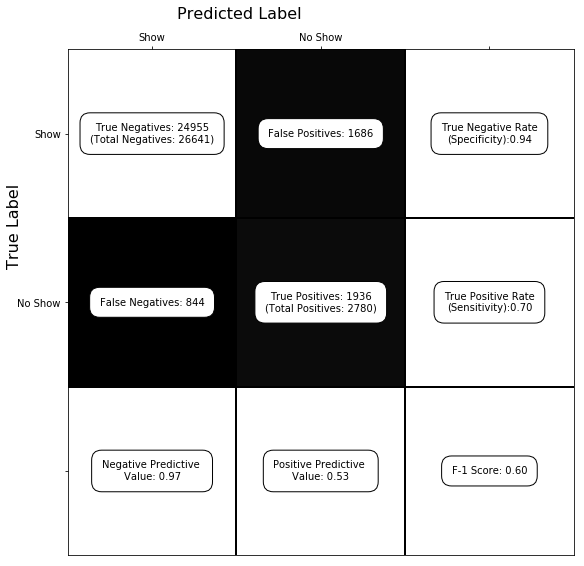

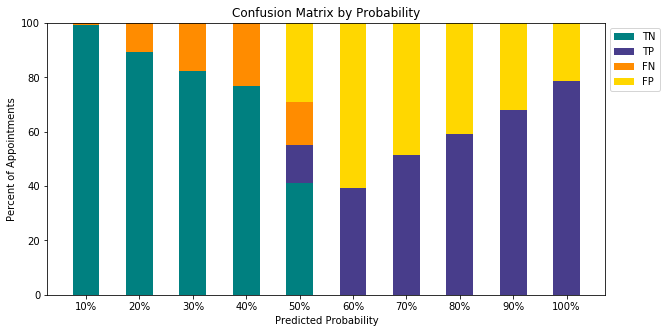

Model Analysis processed in 0.462 seconds.
Pipeline completed in 4154.958 seconds.


In [3]:
results, test, prob, groups, evalstats, sort_features = run_model(df, k = 5000, tune_parameters = True)

## So, what do these mean?
Let's first take a look at the parameters printed from the model:
- Class Weight: balanced
- Criterion: entropy
- Maximum Features: 0.8
- Number of Estimators: 50  


These are based on a small subset of the training set, but it's should still improve the F-1 score of the model when applied to the entire training set. Now we can take a look at the 4 figures generated by the function.
### Sorted Features
- This figure shows which features the model found to be most important. 

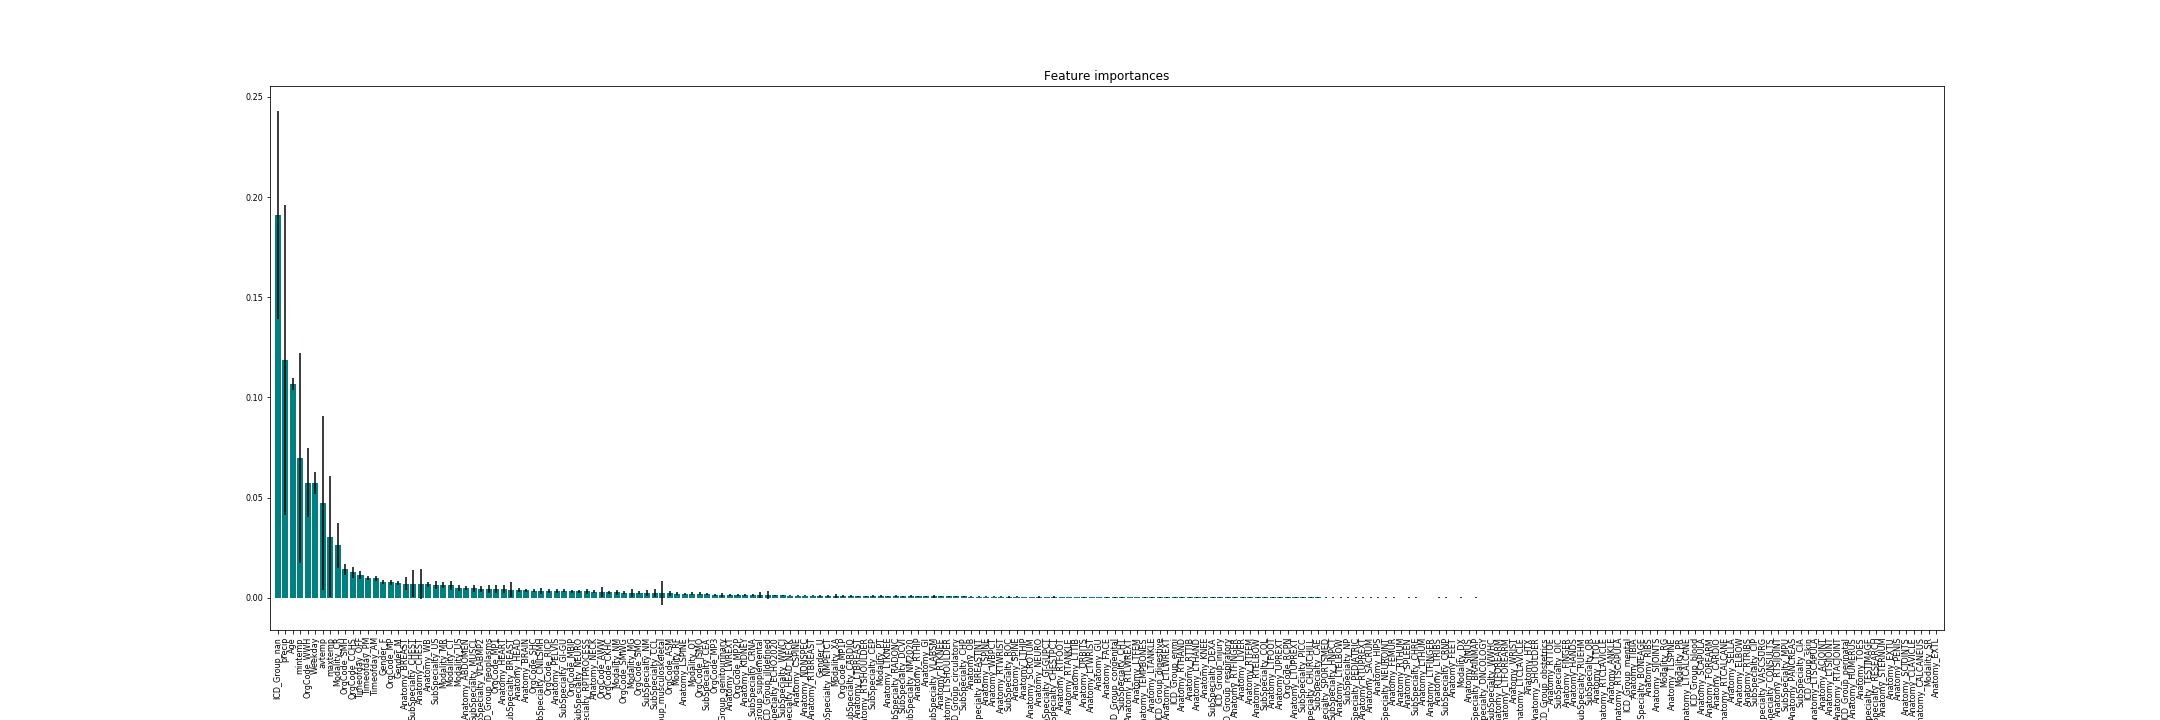

In [11]:
Image(filename='feature_importances.png') 

In [13]:
sort_features[:10]

['ICD_Group_nan',
 'precip',
 'Age',
 'mintemp',
 'OrgCode_WWH',
 'Weekday',
 'avtemp',
 'maxtemp',
 'Modality_CR',
 'OrgCode_SMH']

This shows the top 10 features as determined by the model. It seems that not having an ICD score, interestingly, can help predict a no-show. The other features listed are all of the weather features (Precipitation, Minimum Temperature, Maximum Temperature, and Average Temperature), Age, Weekday, two Hospital features (Westwood Hospital and Santa Monica Hospital), and one modality (CT). It's worth noting that all of the continuous variables in this dataset were deemed to be features with high importance by the model.  


Now let's take a look at the second figure:
### ROC Curve
- ROC, or receiver operating characteristic is plotted to show the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

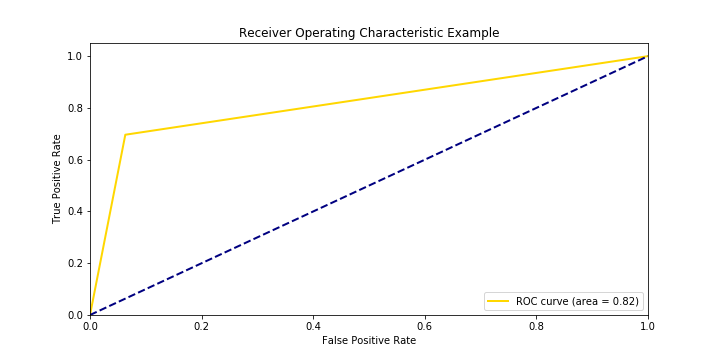

In [14]:
Image(filename='ROC_curve.png') 

This figure indicates the ROC-AUC score is 0.82. This score shows that the models predictive ability is better than a coin flip, but there is definitely room for improvement. Let's dig a little deeper into the data itself.


### The Confusion Matrix with other reported metrics
- This figure contains the following numbers:
    - True Positives (TP): no-shows that were correctly predicted
    - True Negatives (TN): cases that were correctly predicted to show up
    - False Positives (FP): cases the model predicted to no-show, but actually showed up
    - False Negatives (FN): cases the model precited to show up, that actually were no-shows
- It also displays the following metrics:
    - True Negative Rate (Specificity): proportion of negatives that are correctly identified
    - True Positive Rate (Recall/Sensitivity): proportion of positives that are correctly identified
    - F-1 Score: weighted average of Precision and Recall. This metric is more informative than accuracy, for example, for an imbalanced dataset such as this.
        - 2TP / (2TP + FP + FN)
    - Negative Predictive Value: probability that cases with a negative prediction truly will show up
    - Positive Predictive Value: probability that cases with a positive prediction will be noshows

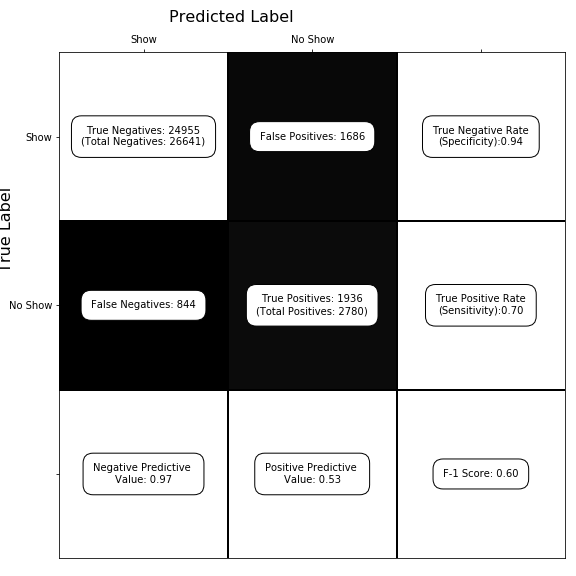

In [15]:
Image(filename='confusionmatrix_withscores.png') 

We can see from this a few things: the model is great at predicting the negative cases (non-cancellations), as illustrated by the negative predictive rate. However, the predictive power for actual no-shows is pretty low; there is almost a 50/50 change the prediction is correct. In line with this, the specificity is higher than the sensitivity. In total, the F-1 Score, which is used as a balanced metric, is slightly higher than 50%, and therefore as a whole only slightly better than a random coin flip.

### Confusion Matrix by Probability
- For all of the predicted cases, the model outputs a probability. This figure utilizes those probabilities by breaking them into ten groups: probabilities from 0 to 0.10, 0.10 to 0.20, and so on, up to 1. From there, the number of true and false values are identified. For probabilites under 0.4, the cases are either True Negatives or False Positives. Above 0.6, all of the cases are True Positives or False Negatives. Between 0.4-0.5, the classifier predicts some of these as positive and some as negative, so this bin has cases that fall into all four categories of the confusion matrix.

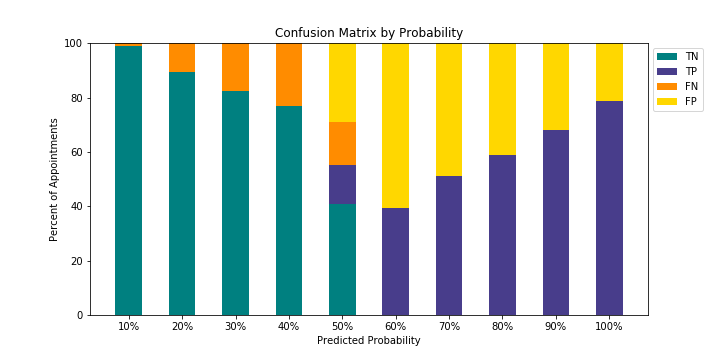

In [17]:
Image(filename='probability_confusionmatrix.png') 

In [18]:
prob

,tn,fp,fn,tp,Sums
P (0.1),21858,0,194,0,22052
P (0.2),1331,0,160,0,1491
P (0.3),811,0,172,0,983
P (0.4),610,0,185,0,795
P (0.5),345,244,133,120,842
P (0.6),0,441,0,286,727
P (0.7),0,380,0,400,780
P (0.8),0,341,0,491,832
P (0.9),0,251,0,532,783
P (1.0),0,29,0,107,136


This graph shows more of the same as we saw above. When the model predicts a probability of 40% - 70%, the liklihood of this being a correct identification is 50% or less. The more extreme probabilities (closer to 0 or 1) have a greater chance of being a correct prediction. Again, we see here that the model is better at predicting the majority case, which is an appointment show.  

There are some thing we could do to improve this model, given more time and/or resources:
- Run a different type of classifier or regression model, which might be more computationally expensive and take more time to run (and therefore, require more time to tune parameters, etc.) Some examples are:
    - Multi-layer Perceptron
    - Logistic Regression
    - Other tree-bosting methods (Gradient Boosting, XGBoost)
    - Support Vector Machine
- Generate different features from the given dataset; it seems that Random Forest likes continuous variables, so that might be one avenue to start.
- Find more data to tackle the imbalance problem
- Run the model to identify sets of cases that are easily classified, then run the model again on subsets of the data that are more difficult to classify.   


And that's it! Any questions can be submitted to: jpolson@g.ucla.edu